In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt  

In [31]:
def cutPic(path):
    # 0 读入原始照片
    img = cv2.imread(path,0)
    # plt.imshow(img,cmap = 'gray')
    # plt.show()
    
    # 1 水表图形分割
    aim = img[0:1000, 700:1000]
    # plt.imshow(aim,cmap = 'gray')
    # plt.show()
    return aim

In [47]:
def preProcess(aim):
    # 2. 预处理
    # 2.1 直方图均衡化提高度对比度

    # 查看原始直方图
    # plt.hist(aim.ravel(),256,[0,256]);  
    # plt.show() 

    # 先平滑后均衡
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(aim,-1,kernel)

    # dst = cv2.GaussianBlur(aim,(5,5),0)

    equ = cv2.equalizeHist(dst)  

    # plt.subplot(121),plt.imshow(aim,cmap = 'gray'),plt.title('Original')
    # plt.xticks([]), plt.yticks([])
    # plt.subplot(122),plt.imshow(equ,cmap = 'gray'),plt.title('Averaging')
    # plt.xticks([]), plt.yticks([])
    # plt.show()

    # 查看平滑后直方图
    # plt.hist(equ.ravel(),256,[0,256]);  
    # plt.show() 
    
    # 2.2 闭运算：先膨胀后腐蚀, 填充前景物体中的小洞
    closing = cv2.morphologyEx(equ, cv2.MORPH_CLOSE, kernel)

    # plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
    # plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
    # plt.subplot(122),plt.imshow(closing, cmap = 'gray')  
    # plt.title('Closing Image'), plt.xticks([]), plt.yticks([])  
    # plt.show()  
    
    # 2.3 图像去噪
    dst_de = cv2.fastNlMeansDenoising(closing, None, 50, 7, 21)

    # plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
    # plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
    # plt.subplot(122),plt.imshow(dst_de, cmap = 'gray')  
    # plt.title('Denoise Image'), plt.xticks([]), plt.yticks([])  
    # plt.show() 
    
    # 2.4 二值化
    ret,thresh = cv2.threshold(dst_de,127,255,0)

    # plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
    # plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
    # plt.subplot(122),plt.imshow(thresh, cmap = 'gray')  
    # plt.title('Thresh Image'), plt.xticks([]), plt.yticks([])  
    # plt.show() 
    
    # 2.5 Canny 边缘检测
    edges = cv2.Canny(thresh,50,150) 
    
    # plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
    # plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
    # plt.subplot(122),plt.imshow(edges, cmap = 'gray')  
    # plt.title('Edge Image'), plt.xticks([]), plt.yticks([])  
    # plt.show()  
    
    # 2.6 轮廓提取
    ret,thresh = cv2.threshold(dst_de,127,255,0)

    contour, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # contour, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])  

    color = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
    result = cv2.drawContours(color, [contour[16]], -1, (0,255,0), 2) #轮廓用绿色绘制

    plt.subplot(122),plt.imshow(result)  
    plt.title('Contours Image'), plt.xticks([]), plt.yticks([])  
    plt.show()  
    
    return equ, contour

In [54]:
def getWaterLine(equ, contour):
    # 3 提取刻度位置

    # 3.1 找出量表轮廓位置
    maxA = 0
    maxS = contour[0].size

    for i in range(0, len(contour)):
        if (contour[i].size > maxS):
            maxA = i
            maxS = contour[i].size 
    # print(maxA, maxS)  

    # 3.2 分割出量表区域 [st : en]
    st = 0
    while (contour[maxA][st][0, 1] < len(equ) / 3 * 2):
        st += 1;
    
    en = st + 1
    while (contour[maxA][en][0, 1] > len(equ) / 3 * 2):
        en += 1; 
    
    # print(st, en)  


    # 3.3 找出最低端零刻度
    Index_0 = 0
    Height_0 = 0
    for i in range(st, en):
        if (contour[maxA][i][0, 1] > Height_0):
            Index_0 = i
            Height_0 = contour[maxA][i][0, 1]

    # print(contour[maxA][Index_0]) # 零刻度位置

    # 3.4 记录零刻度边界
    arr_zero = []

    left_0 = contour[maxA][Index_0][0, 0]
    right_0 = left_0

    for i in range(st, en):
        if (abs(contour[maxA][i][0, 1] - Height_0) < 5):
            arr_zero.append(contour[maxA][i])
            if (contour[maxA][i][0, 0] < left_0):
                left_0 = contour[maxA][i][0, 0]
            if (contour[maxA][i][0, 0] > right_0):
                right_0 = contour[maxA][i][0, 0]    
        
    # print(left_0, right_0) # 零刻度坐标
    
    # 3.5 记录刻度位置数组
    arr_peak = []
    right_bound = left_0 # 水位线左边界
    left_bound = right_0 # 水位线右坐标

    for i in range(st, en):
        i_x = contour[maxA][i][0, 0]
    
        if (i_x > right_bound):
            right_bound = i_x
            
        if (i_x < left_bound):
            left_bound = i_x
            
        peak = True
    
        j = 1
        if (i_x <= contour[maxA][i - j][0, 0]):
            while (i_x == contour[maxA][i - j][0, 0]):
                j += 1
            if (i_x < contour[maxA][i - j][0, 0]):
                peak = False
    
        if (not peak):
            continue
    
        j = 1
        if (i_x <= contour[maxA][i + j][0, 0]):
            while (i_x == contour[maxA][i + j][0, 0]):
                j += 1
            if (i_x < contour[maxA][i + j][0, 0]):
                peak = False
    
        if peak and abs(left_0 - contour[maxA][i][0, 0]) < 10:
            arr_peak.append(contour[maxA][i][0])
            # arr_peak.append(i)
        
        # print(arr_peak) # 刻度坐标 

    # 3.6 计算单位刻度长度
    div = 0
    num = 0
    pre = arr_peak[0][1]
    for i in range(1, len(arr_peak)):
        if abs(arr_peak[i][1] - pre) > 5:
            div += (arr_peak[i][1] - pre)
            num += 1
        pre = arr_peak[i][1]

    lengthPer = div / num # 单位刻度
    # print(lengthPer)
    
    # 3.7 获得轮廓转折点
    # print(left_bound) # 刻度右边界
    rub = en

    for i in range(en, len(contour[maxA])):
        if(contour[maxA][i][0, 0] - right_bound) > 10:
            # print(contour[maxA][i])
            rub = i
            break
        
    # 3.7 寻找水位线
    waterLine = contour[maxA][rub][0, 1]
    # print(waterLine)

    # for i in range(rub, len(contour[maxA]) - 1):
    #     if (contour[maxA][i][0, 1] < waterLine):
    #         # print(contour[maxA][i])
    #         waterLine = contour[maxA][i][0, 1]   
    # print(waterLine)

    # 3.8 计算当前水位
    print("水位线坐标为：[",waterLine, ",", left_bound, "] 到 [",waterLine, ",", right_bound, "]")
    print("当前水位为：", (Height_0 - waterLine) / (lengthPer * 10))

In [60]:
def run():
    path = input("请输入待识别图像路径：")
    # path = "sample8.jpg"
    aim = cutPic(path)
    print("水位轮廓为：")
    equ, contour = preProcess(aim)
    getWaterLine(equ, contour)

请输入待识别图像路径：sample6.jpg
水位轮廓为：


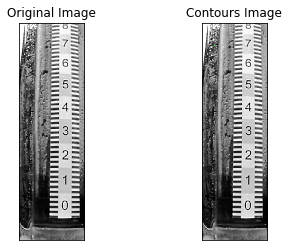

水位线坐标为：[ 641 , 138 ] 到 [ 641 , 280 ]
当前水位为： 1.5653846153846152


In [62]:
run()